In [12]:
import os
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

import random
import shutil

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [13]:
ruta_datos = "../data/raw/train"
ruta_modelos = "../models"

os.makedirs(ruta_modelos, exist_ok=True)

ruta_datos

'../data/raw/train'

Organizar imágenes en subcarpetas (cat/ y dog/)

In [14]:
ruta_gatos = os.path.join(ruta_datos, "cat")
ruta_perros = os.path.join(ruta_datos, "dog")

os.makedirs(ruta_gatos, exist_ok=True)
os.makedirs(ruta_perros, exist_ok=True)

archivos = [f for f in os.listdir(ruta_datos) if f.lower().endswith(".jpg")]

for nombre in archivos:
    origen = os.path.join(ruta_datos, nombre)

    if nombre.startswith("cat."):
        shutil.move(origen, os.path.join(ruta_gatos, nombre))

    elif nombre.startswith("dog."):
        shutil.move(origen, os.path.join(ruta_perros, nombre))

Visualizar 9 perros y 9 gatos

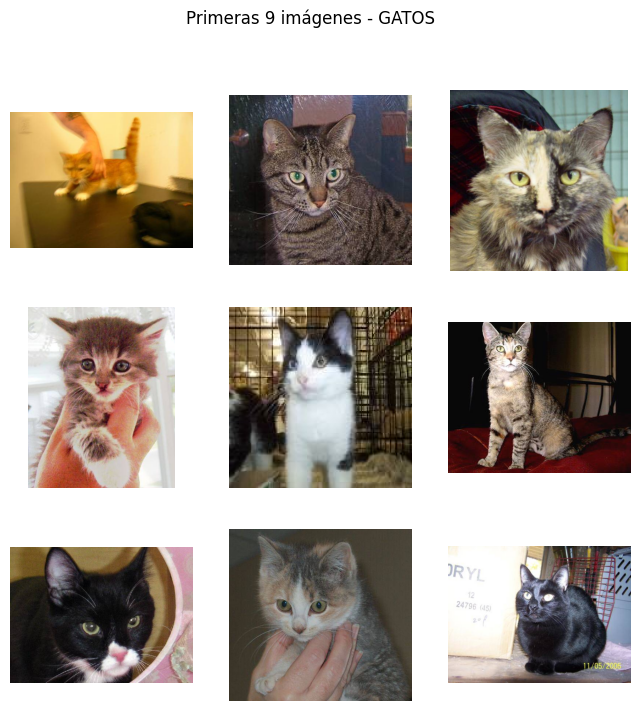

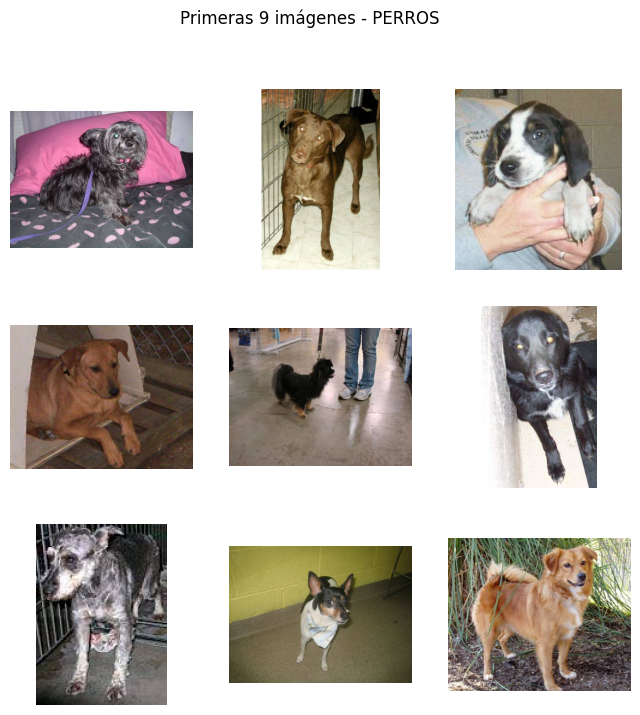

In [15]:
def mostrar_9_imagenes(carpeta, titulo):
    lista_imagenes = sorted([f for f in os.listdir(carpeta) if f.endswith(".jpg")])[:9]

    plt.figure(figsize=(8,8))
    for i, imagen in enumerate(lista_imagenes, 1):
        ruta = os.path.join(carpeta, imagen)
        img = Image.open(ruta).convert("RGB")
        plt.subplot(3,3,i)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(titulo)
    plt.show()

mostrar_9_imagenes(ruta_gatos, "Primeras 9 imágenes - GATOS")
mostrar_9_imagenes(ruta_perros, "Primeras 9 imágenes - PERROS")

# Generadores de datos

In [16]:
tamano_imagen = (160, 160)
tamano_lote = 16

generador_datos = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2)

generador_entrenamiento = generador_datos.flow_from_directory("../data/raw/train",
                                                              target_size=tamano_imagen,
                                                              batch_size=tamano_lote,
                                                              class_mode="binary",     
                                                              subset="training",
                                                              shuffle=True,
                                                              seed=42)

generador_validacion = generador_datos.flow_from_directory("../data/raw/train",
                                                           target_size=tamano_imagen,
                                                           batch_size=tamano_lote,
                                                           class_mode="binary",
                                                           subset="validation",
                                                           shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Modelo

In [17]:
modelo_base = VGG16(weights="imagenet",
                    include_top=False,
                    input_shape=(160,160,3))

modelo_base.trainable = False

modelo = Sequential([ modelo_base,
                     GlobalAveragePooling2D(),
                     Dense(64, activation="relu"),
                     Dropout(0.3),
                     Dense(1, activation="sigmoid")])

modelo.compile(optimizer=Adam(learning_rate=1e-4),
               loss="binary_crossentropy",
               metrics=["accuracy"])

modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Optimización

In [ ]:
ruta_mejor_modelo = os.path.join(ruta_modelos, "mejor_modelo_perros_gatos.keras")

checkpoint = ModelCheckpoint(filepath=ruta_mejor_modelo,
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only=True,
                             verbose=1)

detencion_temprana = EarlyStopping(monitor="val_loss",
                                   patience=2,
                                   restore_best_weights=True)

lista_callbacks = [checkpoint, detencion_temprana]

: 

# Entrenamiento

In [ ]:
epocas = 3

historial = modelo.fit(generador_entrenamiento,
                       validation_data=generador_validacion,
                       epochs=epocas,
                       callbacks=lista_callbacks)

Epoch 1/3
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:52:03 5s/step - accuracy: 0.5156 - loss: 0.7168